In [1]:
from collections import defaultdict
import os
import sys
sys.path.append('..')

import pandas as pd
from tqdm import tqdm
import torch
from allennlp.data.vocabulary import Vocabulary
from allennlp.data.iterators import BasicIterator
from allennlp.nn.util import move_to_device

from adat.utils import load_weights, calculate_wer
from adat.masker import SimpleMasker, MASK_TOKEN
from adat.models import get_basic_classification_model, get_basic_seq2seq_model
from adat.dataset import InsuranceReader, OneLangSeq2SeqReader

In [2]:
! nvidia-smi

Wed Dec 25 22:24:46 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 44%   55C    P2    63W / 280W |   1351MiB / 11178MiB |      9%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:03:00.0 Off |                  N/A |
|  0%   30C    P8     8W / 280W |  10776MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '3'
cuda_device = 3

## Data

In [4]:
max_length = 20
min_length = 2

data = pd.read_csv('../data/full.csv')

data = data[['treatments', 'target']]
treatment_len = data.treatments.apply(lambda x: len(x.split()))
data = data[(treatment_len <= max_length) & (treatment_len >= min_length)]

In [5]:
data.head()

,treatments,target
0,a_178 a_1884 a_1 a_168 a_172 a_174,0
2,a_1978 a_710 a_1677 a_1701 a_1 a_585 a_375 a_...,0
3,a_1257 a_545 a_1128 a_1 a_1191 a_2001 a_1978 ...,0
4,a_737 a_20 a_1257 a_1191 a_642 a_1 a_733 a_11...,0
5,a_719 a_1 a_347 a_340 a_1656 a_885 a_905,0


In [6]:
data['seq_len'] = data.treatments.apply(lambda x: len(x.split()))

negative = data[data.target == 0]
positive = data[data.target == 1]

In [8]:
negative.shape, positive.shape

((293389, 3), (4440, 3))

In [9]:
negative_examples = defaultdict(list)
positive_examples = defaultdict(list)

for row in negative.itertuples():
    negative_examples[row.seq_len].append(row.treatments.strip())
    
for row in positive.itertuples():
    positive_examples[row.seq_len].append(row.treatments.strip())

## Predictors and models

In [10]:
seq2seq_reader = OneLangSeq2SeqReader(masker=None)
seq2seq_vocab = Vocabulary.from_files('vocab_seq2seq_masked')
seq2seq_model = get_basic_seq2seq_model(seq2seq_vocab)
load_weights(seq2seq_model, 'model_seq2seq_masked.th')

In [11]:
class_reader = InsuranceReader()
class_vocab = Vocabulary.from_files('vocab_classification')
class_model = get_basic_classification_model(class_vocab)
load_weights(class_model, 'model_classification.th')

In [12]:
seq2seq_model.cuda(cuda_device)

OneLanguageSeq2SeqModel(
  (_source_embedder): BasicTextFieldEmbedder(
    (token_embedder_tokens): Embedding()
  )
  (_encoder): PytorchSeq2SeqWrapper(
    (_module): LSTM(64, 32, batch_first=True)
  )
  (_attention): AdditiveAttention()
  (_target_embedder): Embedding()
  (_decoder_cell): LSTMCell(96, 32)
  (_output_projection_layer): Linear(in_features=32, out_features=2150, bias=True)
)

In [13]:
class_model.cuda(cuda_device)

BasicClassifier(
  (_text_field_embedder): BasicTextFieldEmbedder(
    (token_embedder_tokens): Embedding()
  )
  (_seq2seq_encoder): PytorchSeq2SeqWrapper(
    (_module): LSTM(32, 16, batch_first=True)
  )
  (_seq2vec_encoder): BagOfEmbeddingsEncoder()
  (_classification_layer): Linear(in_features=16, out_features=2, bias=True)
  (_loss): CrossEntropyLoss()
)

# WER analysis
## positive to negative

In [14]:
iterator = BasicIterator(batch_size=1)
iterator.index_with(seq2seq_vocab)

In [17]:
def calculate_prob_wer_metrics(splitted_examples, result_path, num_attempts=10):
    results = list()
    for seq_len, examples in splitted_examples.items():
        instances = [seq2seq_reader.text_to_instance(seq) for seq in examples]
        for i, example in enumerate(tqdm(iterator(instances, num_epochs=1, shuffle=False))):
            example = move_to_device(example, cuda_device)

            curr_results = dict()
            curr_results['seq_len'] = seq_len
            input_seq = examples[i]

            no_pert_output = seq2seq_model.forward(**example, random_perturbations=False)
            no_pert_decoded = ' '.join(seq2seq_model.decode(no_pert_output)['predicted_tokens'][0])
            no_pert_wer = calculate_wer(input_seq, no_pert_decoded)
            curr_results['no_pert_wer'] = no_pert_wer

            # positive class probability
            no_pert_prob = class_model.forward_on_instance(class_reader.text_to_instance(no_pert_decoded))['probs'][1]
            curr_results['no_pert_prob'] = no_pert_prob

            curr_results['pert_wer'] = list()
            curr_results['pert_prob'] = list()
            for _ in range(num_attempts):
                pert_output = seq2seq_model.forward(**example, random_perturbations=True)
                pert_decoded = ' '.join(seq2seq_model.decode(pert_output)['predicted_tokens'][0])
                pert_wer = calculate_wer(input_seq, pert_decoded)
                curr_results['pert_wer'].append(pert_wer)

                pert_prob = class_model.forward_on_instance(class_reader.text_to_instance(pert_decoded))['probs'][1]
                curr_results['pert_prob'].append(pert_prob)

            with open(result_path, mode='a') as writer:
                writer.write(f"{curr_results}\n")

            results.append(curr_results)
            
    return results

In [18]:
positive_results = calculate_prob_wer_metrics(positive_examples, 'positive_results.txt')

338it [00:43,  7.72it/s]
313it [00:47,  6.55it/s]
301it [00:31,  9.62it/s]
88it [00:24,  3.57it/s]
269it [00:22, 11.81it/s]
133it [00:31,  4.26it/s]
311it [00:55,  5.59it/s]
183it [00:38,  4.75it/s]
156it [00:34,  4.53it/s]
312it [00:44,  7.06it/s]
316it [00:52,  6.06it/s]
123it [00:31,  3.87it/s]
198it [00:40,  4.90it/s]
329it [00:38,  8.58it/s]
283it [00:49,  5.68it/s]
284it [00:27, 10.17it/s]
243it [00:47,  5.07it/s]
121it [00:33,  3.64it/s]
139it [00:10, 13.20it/s]


In [ ]:
negative_results = calculate_prob_wer_metrics(negative_examples, 'neg_results.txt')

16311it [32:31,  8.80it/s]

# Graphs

In [2]:
import sys
sys.path.append('..')

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd

from adat.utils import read_logs

In [4]:
def get_data(logs):
    data = []
    for log in logs:
        results = dict()
        results['wer_diff'] = [wer - log['no_pert_wer'] for wer in log['pert_wer']]
        results['prob_diff'] = [wer - log['no_pert_prob'] for wer in log['pert_prob']]
        for i in range(len(results['prob_diff'])):
            curr_res = dict()
            curr_res['seq_len'] = log['seq_len']
            curr_res['wer_diff'] = results['wer_diff'][i]
            curr_res['prob_diff'] = results['prob_diff'][i]
            data.append(curr_res)
    return pd.DataFrame(data)

In [5]:
positive_data = get_data(read_logs('positive_results.txt'))
negative_data = get_data(read_logs('neg_results.txt'))

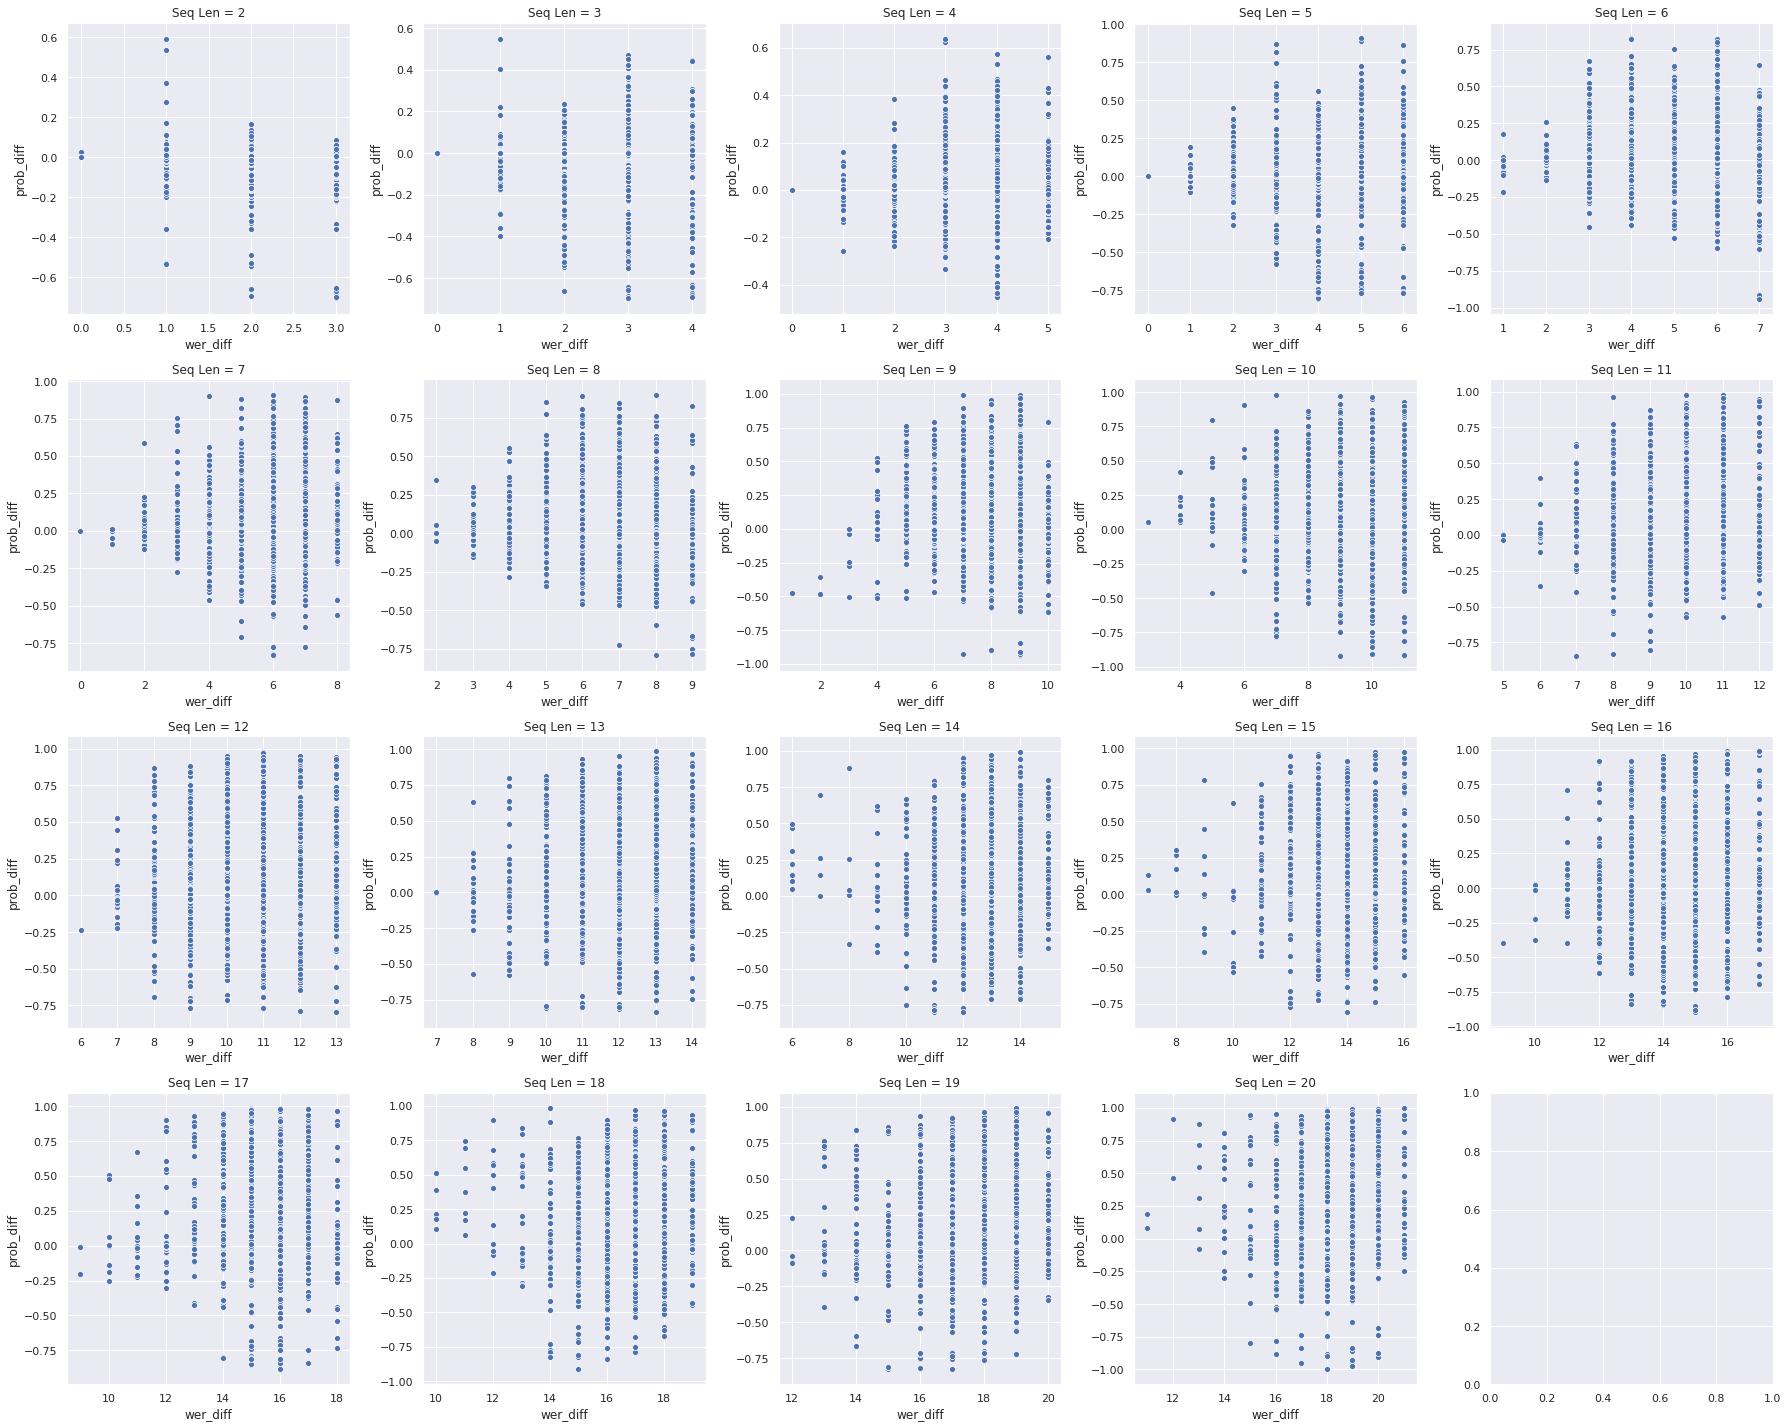

In [6]:
# positive examples

fig, axes = plt.subplots(4, 5, figsize=(25, 20))

for seq_len in range(2, 21):
    curr_data = positive_data[positive_data.seq_len == seq_len][['prob_diff', 'wer_diff']]
    axes[int((seq_len - 2) / 5), (seq_len - 2) % 5].set_title(f'Seq Len = {seq_len}')
    sns.scatterplot(x="wer_diff", y="prob_diff", data=curr_data, ax=axes[int((seq_len - 2) / 5), (seq_len - 2) % 5])
    
fig.tight_layout()

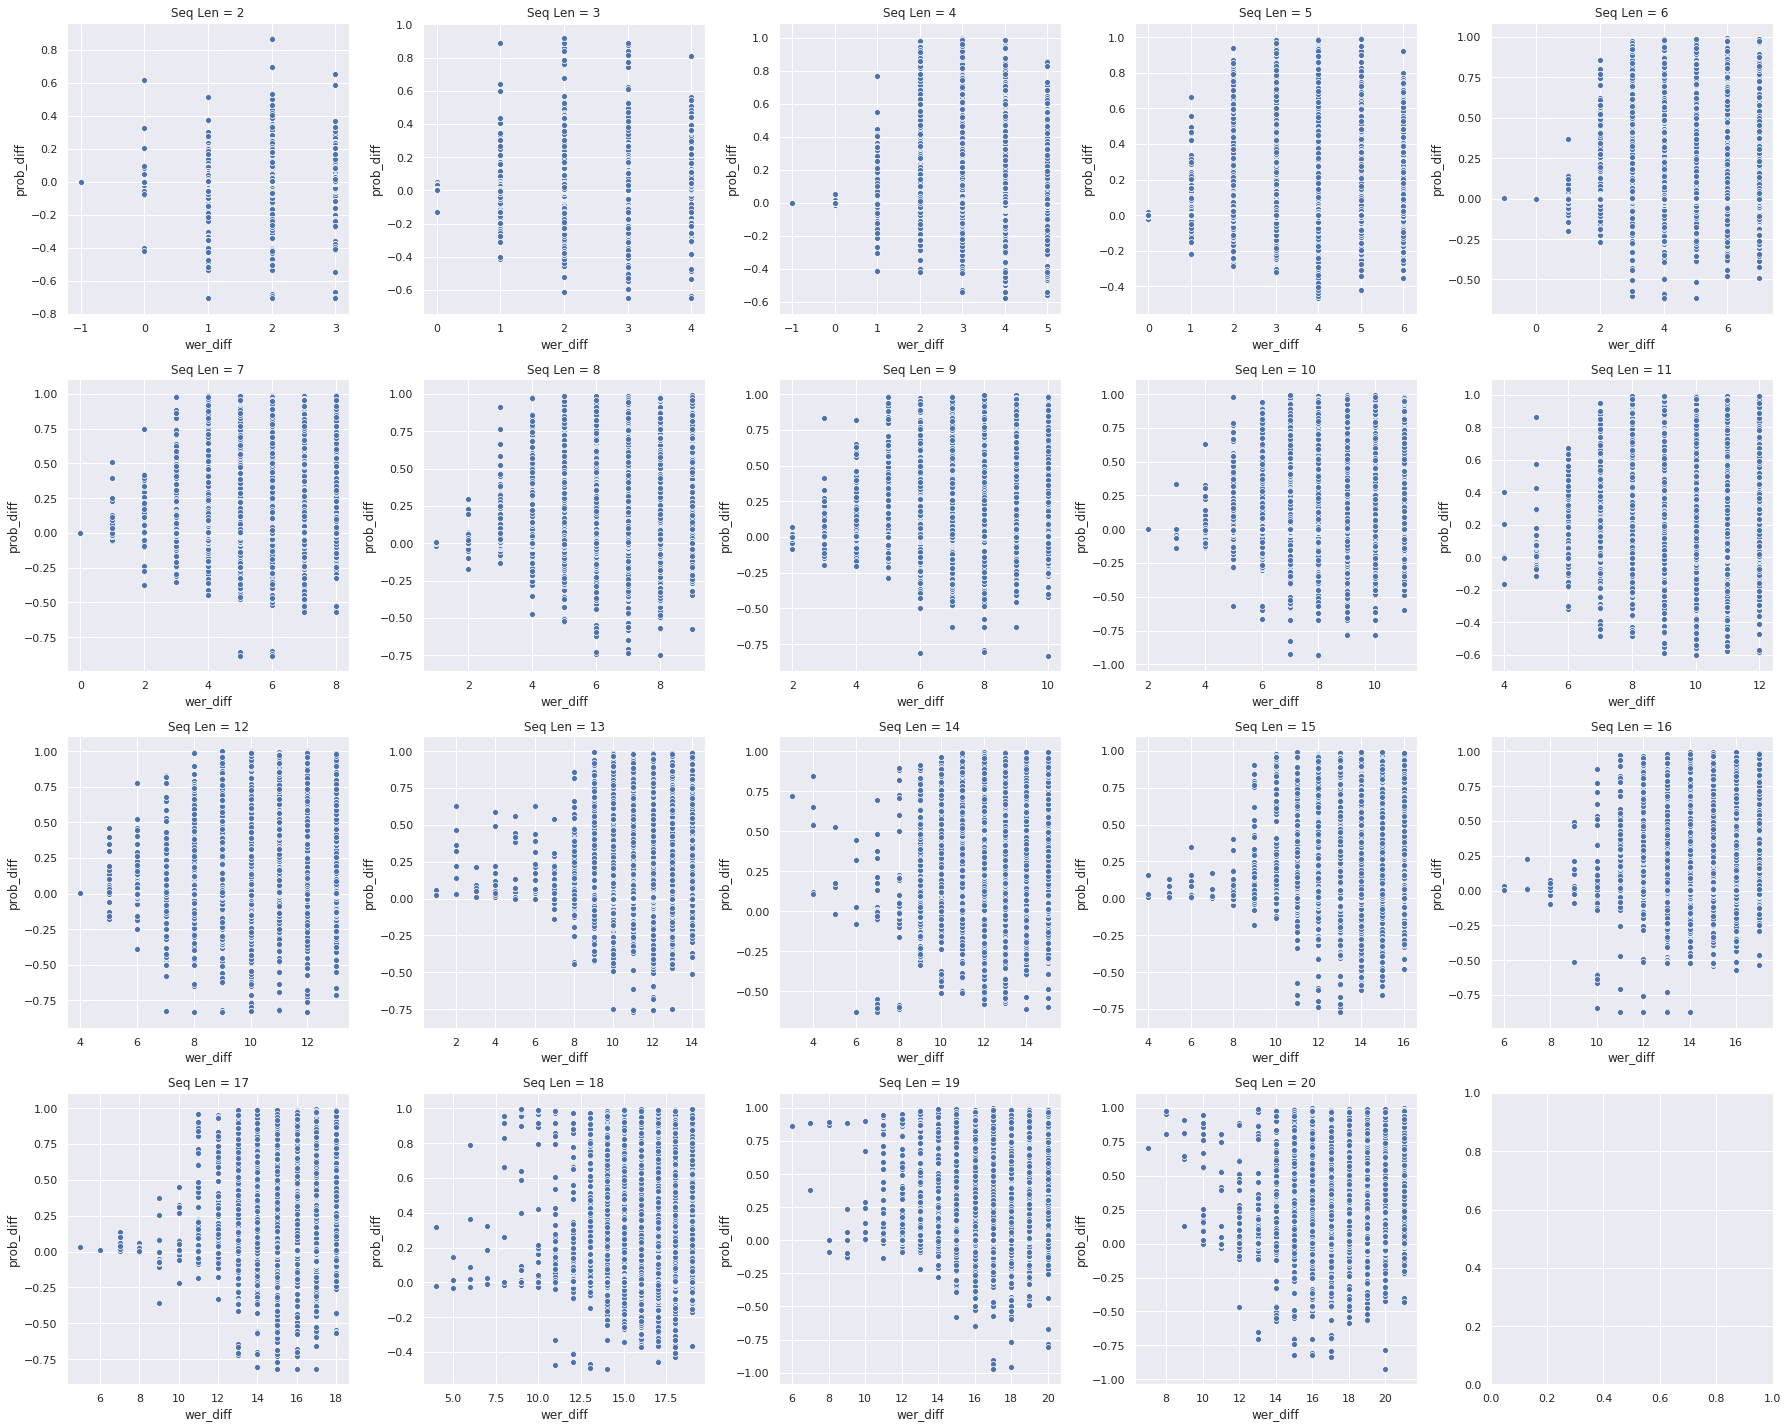

In [7]:
# negative examples

fig, axes = plt.subplots(4, 5, figsize=(25, 20))

for seq_len in range(2, 21):
    curr_data = negative_data[negative_data.seq_len == seq_len][['prob_diff', 'wer_diff']]
    axes[int((seq_len - 2) / 5), (seq_len - 2) % 5].set_title(f'Seq Len = {seq_len}')
    sns.scatterplot(x="wer_diff", y="prob_diff", data=curr_data, ax=axes[int((seq_len - 2) / 5), (seq_len - 2) % 5])
    
fig.tight_layout()